# Funciones

In [13]:
# Para instalar el paquete:
# %pip install uncertainties
import numpy as np
import uncertainties as un
from uncertainties.unumpy import sin as unsine
from uncertainties import unumpy
import os 
from datetime import datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
## La función split redondeado agarra un string de la forma ufloat x+/-y,
## te devuelve su error "y" a una cifra significativa con su valor nominal "x" 
## con la misma cantidad de cifras.
def split_redondeado(x):
    x = [un.ufloat(val.n,val.s) for val in x]
    return np.array([f"{v:.1u}" for v in x])
## La función lam() se usa en las funciones ang2lam() y en registrar_datos().
## Toma un np.array de titos en grados en str, lo pasa a float,
## toma la amplitud de la rendija, el número m,
## el error en grados y el valor de tito_0 que también lo convierte a float
## pasa los angulos a formato ufloat y a radianes y con eso calcula longitudes de onda [nm]
## a los valores calulados de lambda le pone el maximo valor de incertidumbre registrado
def lam(titos, error_angulo, tito_0, d, m):
    diferencia = np.abs(np.array(titos,dtype=float)-np.array(tito_0,dtype=float))
    diferencia_total = diferencia[:,0]+(diferencia[:,1]+diferencia[:,2]/60)/60
    diferencia_total_rad = np.array([un.ufloat(i,error_angulo/3600) for i in diferencia_total]) * np.pi/180
    valores=(d/m) *unsine(diferencia_total_rad)
    err_max = np.max(unumpy.std_devs(valores))
    return np.array([un.ufloat(v.n,err_max)for v in valores])
## registrar_angulo es una función auxiliar de medicion() y registrar_datos() que 
## pide un valor de ángulo en radianes al usuario separado por comas, en la forma
## a[Grados],b[Minutos],c[Segundos] y lo devuelve en forma de lista [a,b,c]
## El valor "centinela" sirve para cortar el loop,
## el valor "i" sirve para indicar que medición está
## y en caso de poner un valor que no se puede convertir a float vuelve a pedir el valor
def registrar_angulo(mensaje,centinela,i):
    while True:
        entrada = input(f"Ingresar el valor del ángulo {i} en la forma a°,b',c'' (SEPARADO POR COMAS) "+mensaje)
        try:
            angulo = [float(i) for i in entrada.split(",")]
            print(f"Su valor del ángulo es {angulo[0]}° {angulo[1]}' {angulo[2]}''")
            break
        except ValueError:
            if entrada in centinela:
                return entrada
            else:
                print("Hubo un error, intente de nuevo y tenga cuidado con las comas")
    return angulo
## El funcionamiento es completamente análogo a registrar_angulo() leer su descripción
## registrar_lambda() se usa en la función registrar_datos()
def registrar_lambda(mensaje,centinela):
    while True:
        entrada = input("Ingresar el valor de lambda en nm "+mensaje)
        try:
            lambdas = float(entrada)
            print(f"Su valor de lambda es {lambdas} nm")
            break
        except ValueError:
            if entrada in centinela:
                return entrada
            else:
                print("Hubo un error, intente de nuevo y tenga cuidado con las comas")    
    return lambdas
## medición() se utiliza en la función registrar_datos()
## utliza la función registrar_angulo() ver descripción para obtener una lista [a,b,c]
## con los datos de los ángulos, devuelve un np.array de dimensiones (N,3) siendo N la cant de dimensiones
def medicion():
    # En esta lista se van a almacenar todos los valores de los angulos en grados
    Lista,i = [],1
    while True:
        # La lista "angulo_grados" sirve para guardar los °,','' del ángulo dato.
        angulo_grados = registrar_angulo("Presione [S] para salir o [E] para rehacer el ángulo anterior","sSEe",f"N° {i}")  
        if str(angulo_grados) in "sS":
            print(f'se terminaron tomando N°{i} mediciones')
            break
        elif str(angulo_grados) in "eE":
            Lista.pop()
        else:
        # Adjuntar el valor
            Lista.append([*angulo_grados])  
        i = len(Lista)
    # Paso todo a un array
    return np.reshape(np.array(Lista),(i,3))
## guardar_csv() se usa en la función registrar_datos()
## guarda los datos del np.array "matriz" en un .csv con el nombre que detende de:
# - nombre_elemento
# - m
## le pone un header en base a la lista "columnas" 
def guardar_csv(matriz, nombre_elemento, columnas,m=0):
    ruta = nombre_elemento 
    # Verificar si la carpeta existe
    if not os.path.exists(ruta):
        os.makedirs(ruta)  
#Lo que hace la variable nombre_archivo es:
#                    carpeta / nombre del elemento _ Lambda o Grados .csv 
    if m==0: #Grados
        nombre_archivo = os.path.join(ruta, f"{nombre_elemento}_Angulo_Grados.csv")
    else: 
        nombre_archivo = os.path.join(ruta, f"{nombre_elemento}_Lambda.csv")
    np.savetxt(nombre_archivo, matriz, delimiter=",", fmt="%s",header=",".join(columnas),comments='')
## metadatos() se usa en la funcion registrar_datos()
## toma los valores de:
# - tito_0 [°,','']
# - nombre_elemento
# - cant de rendijas
# - máximo 
# - error del ángulo
## y lo guarda en un csv
def metadatos(tito_0, nombre_elemento,cant_rendijas,maximo,error):
    # fecha[0] es el año fecha[1] es el mes y fecha[2] es el día
    fecha = datetime.today().strftime("%Y-%m-%d").split("-")
    ruta = nombre_elemento
    # Verificar si la carpeta existe

    nombre_archivo = os.path.join(ruta, "Metadatos" + "_" + nombre_elemento + "_" + fecha[2] + "-" + fecha[1] + "-" +fecha[0]+".csv")
    Datos = np.array([fecha,tito_0,[error,None,None],[nombre_elemento,None,None],[cant_rendijas,None,None],[maximo,None,None]])
    df = pd.DataFrame(Datos)
    df.to_csv(nombre_archivo)
## check() se usa en Pumita_v3.1415() y muestra los espectros registrados hasta el momento
## y permite seleccionar uno y devolver la ruta en la que se encuentra
def check():
    """Muestra los elementos registrados y permite elegir uno.
       Devuelve el nombre de la carpeta seleccionada."""
    carpetas = [d for d in os.listdir() if os.path.isdir(d) and d.startswith("Lab_2_")]
    if not carpetas:
        print("No hay datos registrados todavía.")
        return 
    
    print("Elementos disponibles:")
    for i, carpeta in enumerate(carpetas, start=1):
        print(f"({i}) {carpeta}")
    
    while True:
        try:
            eleccion = int(input("Ingrese el número del elemento que desea revisar: "))
            if 1 <= eleccion <= len(carpetas):
                return carpetas[eleccion-1]
            else:
                print("Número inválido, intente de nuevo.")
        except ValueError:
            print("Entrada inválida, por favor ingrese un número.")
## leer_csv() se usa en mostrar_datos() y lee los datos de un archivo CSV.
## Toma el nombre del archivo (Nombre) y el tipo de datos (tipo) como entrada.
## Devuelve un array de NumPy con los datos del archivo.
def leer_csv(Nombre, tipo,cols=1):
    archivos = [f for f in os.listdir(Nombre) if tipo in f]
    if not archivos:
        print(f"No se encontró archivo de {tipo} en esta carpeta.")
        return None
    archivo = os.path.join(Nombre, archivos[0])
    if cols!=-1:
        return np.loadtxt(archivo, delimiter=",", skiprows=1,usecols=(i for i in range(1,cols+1)), dtype=str)
    else:
        return np.loadtxt(archivo, delimiter=",", skiprows=1, dtype=str)
## ang2lam() se usa en mostrar_datos() y calcula los valores de lambda a partir de los datos de ángulos y metadatos.
## Toma un array de NumPy con los datos de ángulos (np_ang) y un array de NumPy con los metadatos (np_meta) como entrada.
## Devuelve un DataFrame de pandas con los valores de lambda calculados.
def ang2lam(np_ang, np_meta):
    # df_ang: DataFrame con columnas Grados, Minutos, Segundos
    n = float(np_meta[4,0]) # Rendijas por mm
    d = un.ufloat(1000000/n, 10000/n)
    tito_0 = np_meta[1,:]
    error_angulo = float(np_meta[2][0])
    m = int(np_meta[5,0])
    # Solo columnas de grados, minutos, segundos
    lambdas = lam(np_ang[:,0:3], error_angulo, tito_0, d, m)
    lambdas_str = split_redondeado(lambdas)
    df_lambdas = pd.DataFrame(lambdas_str, columns=["(Lambda +/- Error) nm"])
    return df_lambdas,lambdas
## mostrar_datos() se usa en Pumita_v3.1415() y muestra los datos de un espectro, ya sean medidos o tabulados.
## Toma el nombre del elemento (Nombre) y el tipo de datos (tipo) como entrada.
## Devuelve un array de NumPy con los valores de lambda (solo para datos tabulados) o None (para datos medidos).
def mostrar_datos(Nombre,tipo="0"):
    if tipo=="Tab":
        mask = leer_csv(Nombre, "Lambda",-1)
        lam = np.array([un.ufloat_fromstr(l) for l in mask.flatten()])
        lambda_tab_np = split_redondeado(lam)
        df_lambda = pd.DataFrame(lambda_tab_np, columns=["(Lambda +/- Error) nm"])
        print("="*32)
        print(" Resultados de los Lambda en nm")
        print("="*32)
        display(df_lambda)
        return np.array([un.ufloat_fromstr(l) for l in lambda_tab_np.flatten()])
    else:
        angulos_np = leer_csv(Nombre, "Angulo",cols=-1)
        df_angulos = pd.DataFrame(angulos_np,columns=["Grados","Minutos","Segundos"])
        metadatos_np = np.reshape(leer_csv(Nombre, "Metadatos",cols=3),(6,3))

        print("="*30)
        print(" Metadatos del experimento")
        print("="*30)
        df_metadatos = pd.DataFrame(metadatos_np,index=[ "Fecha","Tito_0","Error angular [seg/arc°]","Nombre","Rendijas por mm", "Cant. máximos"])
        display(df_metadatos)
        print("="*39)
        print(" Mediciones de los Ángulos en grados")
        print("="*39)
        display(df_angulos)
        df_lambdas_calc,lambdas_med_np = ang2lam(angulos_np, metadatos_np)
        print("="*32)
        print(" Resultados de los Lambda en nm")
        print("="*32)
        display(df_lambdas_calc)
        return lambdas_med_np
## wavelength_to_rgb() se usa en plot_emission_lines() y convierte una longitud de onda en nanómetros a un color RGB.
## Toma la longitud de onda (wavelength) como entrada.
## Devuelve una tupla con los valores RGB correspondientes a la longitud de onda.
def wavelength_to_rgb(wavelength, gamma=0.8):
    wl = float(wavelength)
    if wl < 380 or wl > 750:
        return (0.0, 0.0, 0.0)
    if wl < 440:
        r = -(wl - 440) / (440 - 380)
        g = 0.0
        b = 1.0
    elif wl < 490:
        r = 0.0
        g = (wl - 440) / (490 - 440)
        b = 1.0
    elif wl < 510:
        r = 0.0
        g = 1.0
        b = -(wl - 510) / (510 - 490)
    elif wl < 580:
        r = (wl - 510) / (580 - 510)
        g = 1.0
        b = 0.0
    elif wl < 645:
        r = 1.0
        g = -(wl - 645) / (645 - 580)
        b = 0.0
    else:
        r = 1.0
        g = 0.0
        b = 0.0
    if wl < 420:
        factor = 0.3 + 0.7 * (wl - 380) / (420 - 380)
    elif wl > 645:
        factor = 0.3 + 0.7 * (750 - wl) / (750 - 645)
    else:
        factor = 1.0
    r = (r * factor) ** gamma
    g = (g * factor) ** gamma
    b = (b * factor) ** gamma
    return (max(0, r), max(0, g), max(0, b))
## plot_emission_lines() se usa en plot() y genera un gráfico de líneas de emisión.
## Toma un array de NumPy con los valores de lambda (lambdas) y un título (title) como entrada.
## Muestra el gráfico generado.
def plot_emission_lines(lambdas,lim, title="Espectro", figsize=(10,3),save_svg=None):
    # Busco los limites teniendo en cuenta los valores medidos y los tabulados
    # lambdas: array de strings tipo "xxx+/-yy"

    wavelengths = unumpy.nominal_values(lambdas)
    errors = unumpy.std_devs(lambdas)


    wavelengthslim = unumpy.nominal_values(lim)
    errorslim = unumpy.std_devs(lim)

    xlim = (min(*wavelengths,*wavelengthslim)-1.5*max(*errors,*errorslim), max(*wavelengths,*wavelengthslim)+1.5*max(*errors,*errorslim))
    fig, ax = plt.subplots(figsize=figsize, facecolor='black')
    ax.set_facecolor('black')
    ax.set_xlim(*xlim)
    ax.set_ylim(-0.12, 1.0)
    ax.set_yticks([])
    ax.set_xlabel("Longitud de onda (nm)", color="white")
    ax.set_title(title, color="white")
    for lam, err in zip(wavelengths, errors):
        col = wavelength_to_rgb(lam)
        if err > 0:
            ax.fill_betweenx([0,0.95], lam - err, lam + err, color=col, alpha=0.18, linewidth=0)
        ax.axvline(lam, color=col, linewidth=1.5, alpha=0.95, zorder=3)
    ax.tick_params(axis='x', colors='white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    plt.tight_layout()
    if save_svg is not None:
        # guardar respetando el color de fondo
        fig.savefig(save_svg, format='svg', facecolor=fig.get_facecolor(), dpi=300)
    plt.show()
## plot_emission_lines_superpuestos() se usa en plot() y genera un gráfico de líneas de emisión superpuestas.
## Toma dos arrays de NumPy con los valores de lambda (lambdas_medidos y lambdas_tabulados) y un título (title) como entrada.
## Muestra el gráfico generado.
def plot_emission_lines_superpuestos(lambdas_medidos, lambdas_tabulados, title="Espectro comparado", figsize=(10,3),save_svg=None): 

    # Convertir strings a ufloats
    wavelengths_med = unumpy.nominal_values(lambdas_medidos)
    errors_med = unumpy.std_devs(lambdas_medidos)
    wavelengths_tab = unumpy.nominal_values(lambdas_tabulados)
    errors_tab = unumpy.std_devs(lambdas_tabulados)

    # Eje x común
    xlim = (min(np.min(wavelengths_med - 2*errors_med), np.min(wavelengths_tab - 2*errors_tab)),
        max(np.max(wavelengths_med + 2*errors_med), np.max(wavelengths_tab + 2*errors_tab)))

    fig, ax = plt.subplots(figsize=figsize, facecolor='black')
    ax.set_facecolor('black')
    ax.set_xlim(*xlim)
    ax.set_ylim(-0.12, 1.0)
    ax.set_yticks([])
    ax.set_xlabel("Longitud de onda (nm)", color="white")
    ax.set_title(title, color="white")

    # Medidos: azul
    for lam, err in zip(wavelengths_med, errors_med):
        col = (0.2, 0.6, 1.0)  # azul
        if err > 0:
            ax.fill_betweenx([0,0.45], lam - err, lam + err, color=col, alpha=0.18, linewidth=0)
        ax.axvline(lam, color=col, linewidth=1.5, alpha=0.95, zorder=3, label="Medido")
    # Tabulados: naranja
    for lam, err in zip(wavelengths_tab, errors_tab):
        col = (1.0, 0.5, 0.1)  # naranja
        if err > 0:
            ax.fill_betweenx([0.55,1.0], lam - err, lam + err, color=col, alpha=0.18, linewidth=0)
        ax.axvline(lam, color=col, linewidth=1.5, alpha=0.95, zorder=3, label="Tabulado")

    # Leyenda (solo una vez cada tipo)
    handles = [
        plt.Line2D([0], [0], color=(0.2,0.6,1.0), lw=1.5, label="Medido"),
        plt.Line2D([0], [0], color=(1.0,0.5,0.1), lw=1.5, label="Tabulado")
    ]
    ax.legend(handles=handles, loc="upper right", facecolor='black', framealpha=0.7, labelcolor='white')
    ax.tick_params(axis='x', colors='white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    plt.tight_layout()
    if not save_svg is None:
        # guardar respetando el color de fondo
        fig.savefig(save_svg, format='svg', facecolor=fig.get_facecolor(), dpi=300)
    plt.show()
## plot() se usa en Pumita_v3.1415() y genera los gráficos de líneas de emisión, tanto superpuestos como individuales.
## Toma dos arrays de NumPy con los valores de lambda (lambdas_med_np y lambdas_tab_np), el nombre del elemento (Nombre) y un booleano (all) como entrada.
## Muestra los gráficos generados y guarda los gráficos en archivos SVG si all es True.
def plot(lambdas_med_np,lambdas_tab_np,Nombre,all=True,Desplazamiento=""):
    if all:
        plot_emission_lines_superpuestos(lambdas_med_np,lambdas_tab_np,title=f"Espectro comparado del {Nombre.replace('_Tabulado','').replace('Lab_2_','')}",save_svg=f"{Nombre.replace('_Tabulado','')}/{Nombre.replace('_Tabulado','')}_Espectro_Comparado.svg")
        plot_emission_lines(lambdas_med_np, lambdas_tab_np, title=f"Espectro medido del {Nombre.replace('_Tabulado','').replace('Lab_2_','')}", figsize=(10,3),save_svg=f"{Nombre.replace('_Tabulado','')}/{Nombre.replace('_Tabulado','')}_Espectro_Medido.svg")
        plot_emission_lines(lambdas_tab_np, lambdas_med_np, title=f"Espectro tabulado del {Nombre.replace('_Tabulado','').replace('Lab_2_','')}", figsize=(10,3),save_svg=f"{Nombre.replace('_Tabulado','')}/{Nombre.replace('_Tabulado','')}_Espectro_Tabulado.svg")
    else:
        plot_emission_lines_superpuestos(lambdas_med_np,lambdas_tab_np,title=f"Espectro desplazado comparado del {Nombre.replace('_Tabulado','').replace('Lab_2_','')}",save_svg=f"{Desplazamiento+Nombre.replace('_Tabulado','')}/{Nombre.replace('_Tabulado','')}_Espectro_Comparado.svg")
## registrar_datos() se usa en Pumita_v3.1415() y registra los datos de un espectro, ya sean medidos o tabulados.
## Toma el tipo de datos (Tipo) como entrada.
## Devuelve el nombre del elemento (Nombre) y el tipo de datos ("Med" para medidos, "Tab" para tabulados).
def registrar_datos(Tipo):
    if Tipo == "0": # Espectrometro
        ## Empezamos con el error del instrumento y el tito_0
        error_angulo = float(input("Ingrese el error del instrumento en segundos de arco"))
        tito_0 = registrar_angulo("","ħ","tito_0")

        ## Empezamos con el nombre del elemento al que le medimos las lineas
        Nombre = "Lab_2_"+ input("ingrese el nombre del elemento")
        ## Ancho de las rendijas 
        n = float(input("ingrese la cantidad de líneas por milímetro que posee la rendija de difracción")) 
        # 1 000 000 [nm] entre n líneas es la distancia entre rendijas con un 1% de error
        d = un.ufloat(1000000/n,10000/n)
        ## Usamos el máximo principal
        m = int(input("ingrese el máximo que va a medir m:1,2,3,... "))
        while m<=0:
            m = int(input("Ingrese un m entero mayor que 0"))

        # Inicio el programa de adquisición de angulos y transformación a radianes
        Angulos = medicion()
        
        ## Hacer el calculo para el lambda
        Lambda_medido = lam(Angulos,error_angulo,tito_0,d,m)
        
        guardar_csv(Angulos,Nombre,["Grados","Minutos","Segundos","error seg/arc°"])
        guardar_csv(Lambda_medido,Nombre,["(Lambda +/- Error) nm"],-1)
        metadatos(tito_0,Nombre,n,m,error_angulo)
        return Nombre,"Med"
    else:
        Nombre = "Lab_2_"+input("ingrese el nombre del elemento")+"_Tabulado"
        error  = float(input("Ingrese la incertidumdre de las mediciones en nm"))
        Lambdas = []
        while True:

            Lam = registrar_lambda("presione [s] para terminar de registrar o [e] para rehacer la entrada anterior","sSeE")
            if str(Lam) in "sS":
                Lambdas = np.array(Lambdas)
                break   
            elif str(Lam) in "eE":
                Lambdas.pop()
            else:
                Lambdas.append(un.ufloat(float(Lam),error))
        guardar_csv(Lambdas,Nombre,["(Lambda +/- Error) nm"],-1)
        return Nombre,"Tab"
## Pumita_v3_1415() es la función principal del programa.
## Permite al usuario ingresar nuevos datos, revisar datos ya escritos o salir del programa.
def Pumita_v3_1415():
    print("Tutturuu~!")
    salir = True
    while salir:
        Nuevo_viejo = input("Desea ingresar nuevos datos (0), revisar datos ya escritos (1), salir (2)")
        if Nuevo_viejo in "0": # Nuevos datos
            clear_output(wait=True)
            Tipo = input("Los datos registrados son del espectrómetro (0), un espectro tabulado (1)")
            Nombre,op = registrar_datos(Tipo) 
            lambdas_med_np = mostrar_datos(Nombre,op)
            lambdas_tab_np = 0
        elif Nuevo_viejo in "1": # Datos ya escritos
            clear_output(wait=True)
            Nombre = check()    
            if Nombre in "_Tabulado":
                Nombre = Nombre.replace("_Tabulado","")
                lambdas_med_np, = mostrar_datos(Nombre)
            else:
                lambdas_med_np = mostrar_datos(Nombre)
            lambdas_tab_np = mostrar_datos(Nombre+"_Tabulado","Tab")
            plot(lambdas_med_np,lambdas_tab_np,Nombre)
        else: # Salir
            break
        
    print("gracias por usar Pumita v3.1415")
    
    return lambdas_med_np,lambdas_tab_np

## Update 3.1:
- Ahora la función Pumita v3.1 te pide directamente el valor de tito_0
- Guarda datos extra en un csv como la fecha, el m usado, la cantida de rendijas y el valor de tito_0 en grados

Para que funcione el codigo debes ejecutar las dependencias, las funciones y la celda de abajo.

## Update 3.14
- Ahora puedes acceder a los datos mediante una interfaz gráfica en la salida de comandos

## Update 3.141
- Ahora se pueden hacer gráficas
- Opcion de guardar espectros tabulados

## Update 3.1415
- Completar
### ¿Qué hace?
Muchas cosas.
~~Antes de empezar ES IMPORTANTE modifificar~~ el valor de tito_0 que sería tu 0 angular.

El programa pide diferente mediciones del ángulo en la forma x° y' z'' y la transforma a radianes con una incertdumbre por defecto de 15''.

Luego, guarda los resultados en un csv en una carpeta con el nombre del elemento.

Luego, hace los cálculos de $\lambda$ ~~teniendo como predeterminado m = 1~~ y hace el mismo procedimiento de guardado que para los ángulos.

Para acceder a los datos hay dos opciones:
- Usar la variable Lambda_medido con la función split_redondeado(Lambda_medido[i],"ufloat")
- ~~Acceder desde el csv usando una función que no quise hacer~~ así que si de casualidad la haces estaría muy agradecido que la subas a https://github.com/FabriTape/Exp-2-Lab-2-Emision-de-gases-
- Ahora la función ya existe y esta integrada en el funcionamiento de Pumita v3.141

# Funcionamiento principal


Elementos disponibles:
(1) Lab_2_He
(2) Lab_2_Hg
(3) Lab_2_He_Tabulado
(4) Lab_2_Kr
(5) Lab_2_Dióxido de carbono_Tabulado
(6) Lab_2_Ar_Tabulado
(7) Lab_2_Hg_Tabulado
(8) Lab_2_Kr_Tabulado
(9) Lab_2_Dióxido de carbono
(10) Lab_2_Ar
 Metadatos del experimento


,0,1,2
Fecha,2025,09,12
Tito_0,216.0,24.0,0.0
Error angular [seg/arc°],15.0,,
Nombre,Lab_2_Fredy,,
Rendijas por mm,300.0,,
Cant. máximos,1,,


 Mediciones de los Ángulos en grados


,Grados,Minutos,Segundos
0,209.0,12.0,30.0
1,209.0,7.0,30.0
2,209.0,1.0,30.0
3,208.0,42.0,0.0
4,208.0,7.0,0.0
5,207.0,15.0,0.0
6,207.0,4.0,30.0
7,206.0,29.0,0.0
8,206.0,5.0,30.0


 Resultados de los Lambda en nm


,(Lambda +/- Error) nm
0,418+/-6
1,423+/-6
2,429+/-6
3,481+/-6
4,480+/-6
5,530+/-6
6,541+/-6
7,584+/-6
8,597+/-6


 Resultados de los Lambda en nm


,(Lambda +/- Error) nm
0,420+/-5
1,440+/-5
2,460+/-5
3,495+/-5
4,525+/-5
5,550+/-5
6,560+/-5
7,570+/-5
8,595+/-5


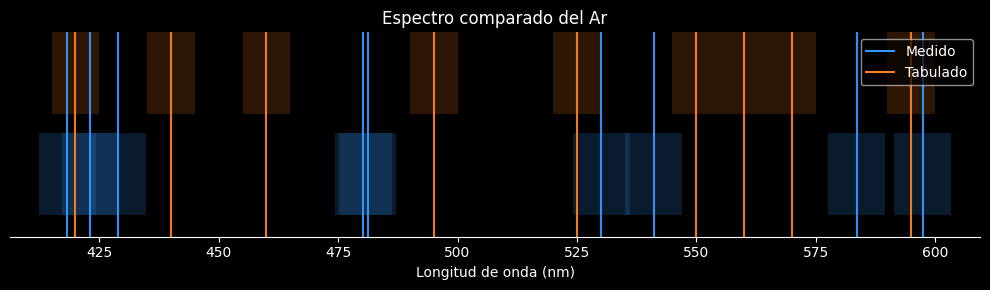

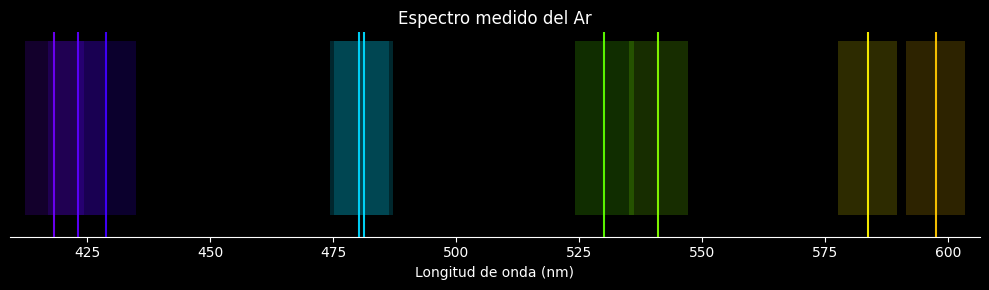

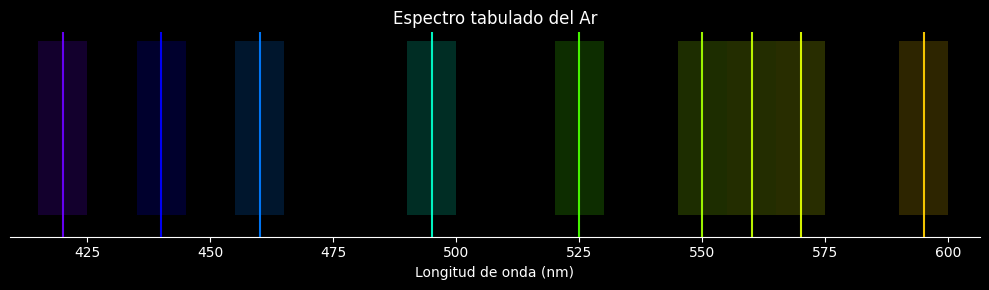

gracias por usar Pumita v3.1415


In [15]:
lambdas_med_np,lambdas_tab_np = Pumita_v3_1415()

In [ ]:
def proy_cos(a,b):
    return np.dot(a,b)/un.umath_core.sqrt(np.dot(a,a)*np.dot(b,b))
def cos_prod(a,b,delta):
    x=[]
    for i in delta:
        va=a+i
        dif=va-b
        x.append(np.sum([j**2 for j in dif ])**(1/2))
    return np.array([un.ufloat(a.n,a.s) for a in x])
def find(arr,val,x):
    for i,v in enumerate(arr):
        if v==val:
            return x[i]
        elif (v-val)*(arr[i-1]-val)<0:
            return x[i]
def proy(lambdas_med_np,lambdas_tab_np):
    x=np.linspace(-30,30,90)
    u = cos_prod(lambdas_med_np,lambdas_tab_np,x)
    uu = min(u)
    x_min= find(u,uu,x)
    x_min_del = find(u,uu.n+uu.s,x)
    val_x= un.ufloat(x_min,abs(x_min-x_min_del))
    clear_output()
    return val_x
def lam2ang(lam):
    d = un.ufloat(10000/3,100/3)
    return unumpy.arcsin(lam/d)*180*60/np.pi
def error_sist(Nom):
    Nombre=f"Lab_2_{Nom}"
    lambdas_med_np  = mostrar_datos(Nombre)
    lambdas_tab_np  = mostrar_datos(Nombre+"_Tabulado","Tab")
    clear_output(wait=True)
    mean_proy = -np.mean(lambdas_med_np-lambdas_tab_np)
    mean_proy = un.ufloat(mean_proy.n,mean_proy.s)
    val_x = proy(lambdas_med_np,lambdas_tab_np)
    a = np.array([un.ufloat(v.n,v.s)for v in lambdas_med_np+val_x])
    b = np.array([un.ufloat(v.n,v.s)for v in lambdas_med_np+mean_proy])
    plot(a,lambdas_tab_np,Nombre,False,"Desplazamiento/")
    plot(b,lambdas_tab_np,Nombre,False,"Desplazamiento/")
    plot(lambdas_med_np,lambdas_tab_np,Nombre,True)
    
    print("Minimos cuadrados:\n",val_x, "nm","\n",lam2ang(val_x),"Minutos")
    print("Proyeccion del coseno:",proy_cos(a,lambdas_tab_np))

    print("Proyección:\n",mean_proy, "nm","\n",lam2ang(mean_proy),"Minutos")
    print("Proyeccion del coseno:",proy_cos(lambdas_med_np,lambdas_tab_np))




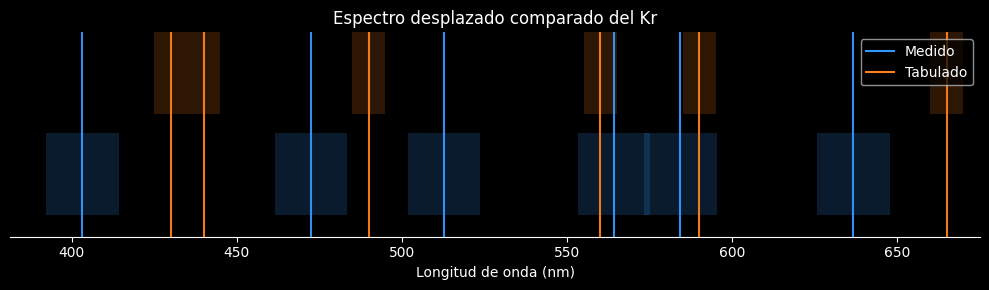

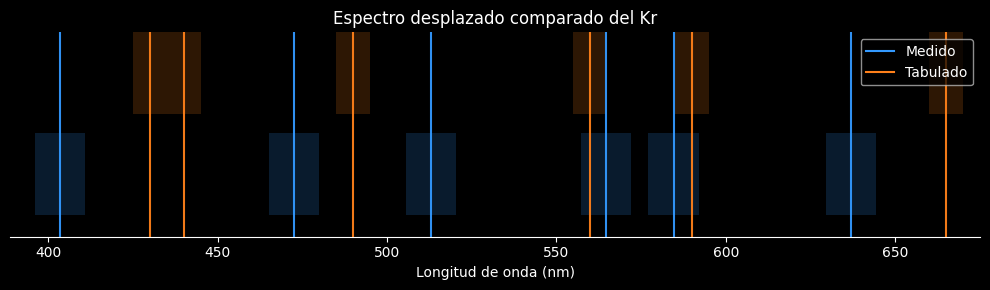

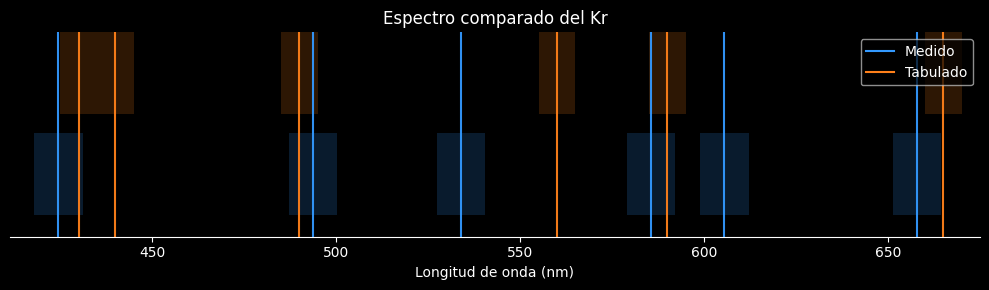

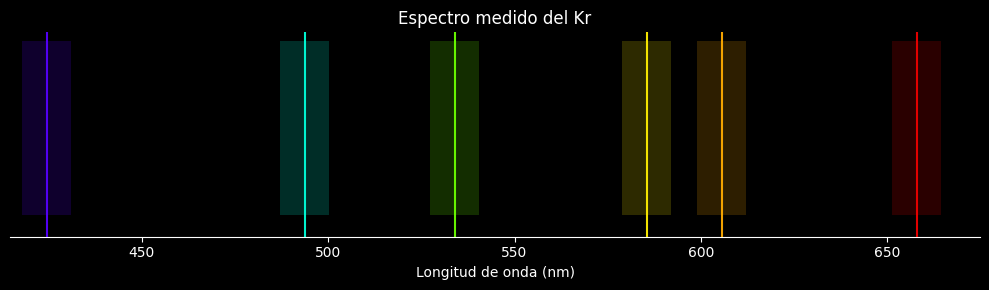

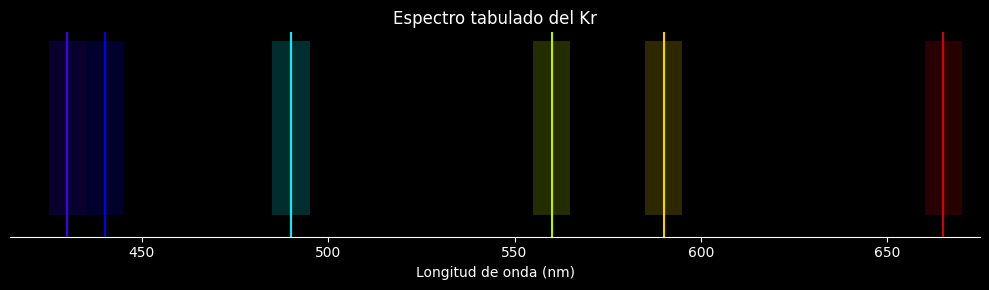

Minimos cuadrados:
 -21+/-9 nm 
 -22+/-9 Minutos
Proyeccion del coseno: 0.9987+/-0.0005
cos(theta) ≈ 0.998541 ± 0.000482 (MC, 1σ)
Proyección:
 -21.0+/-3.4 nm 
 -21.7+/-3.5 Minutos
Proyeccion del coseno: 0.99870+/-0.00031
cos(theta) ≈ 0.998509 ± 0.000474 (MC, 1σ)


In [53]:
error_sist("Kr")

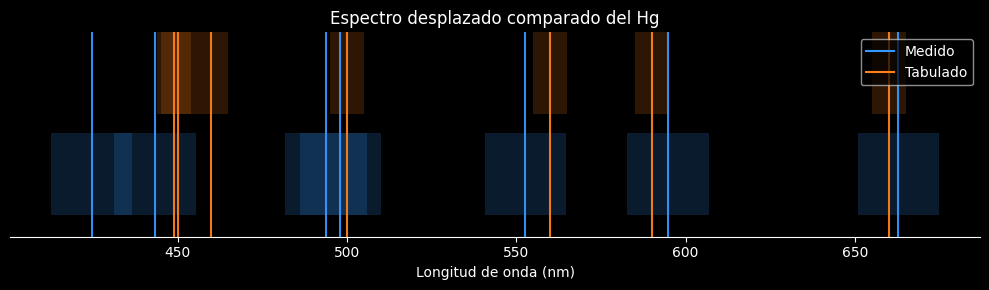

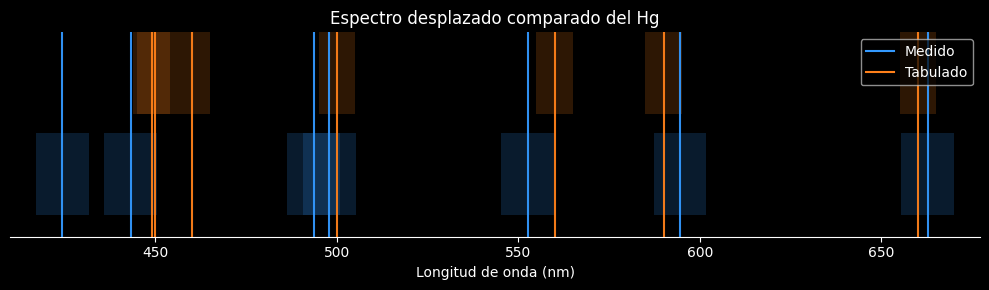

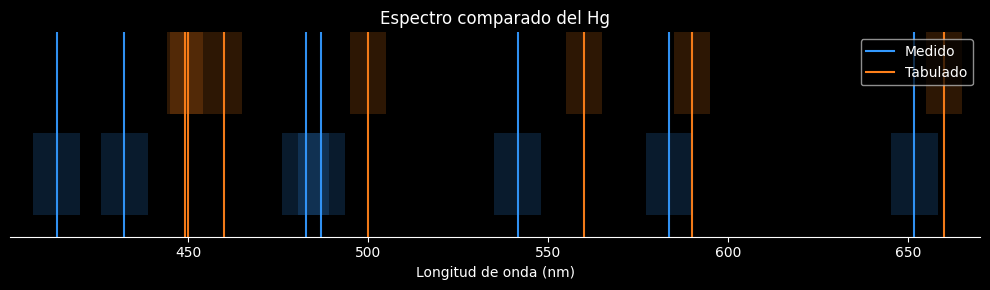

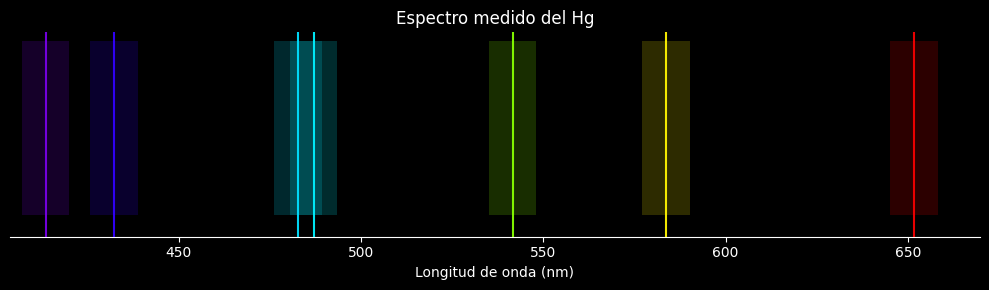

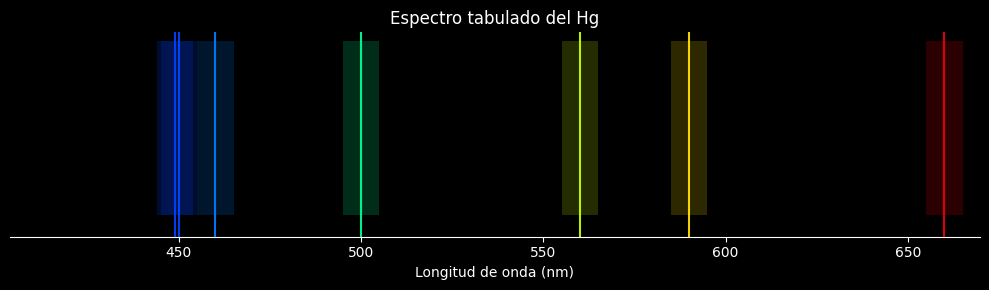

Minimos cuadrados:
 11+/-10 nm 
 11+/-10 Minutos
Proyeccion del coseno: 0.99953+/-0.00029
Proyección:
 11.0+/-3.1 nm 
 11.3+/-3.2 Minutos
Proyeccion del coseno: 0.99949+/-0.00019


In [45]:
error_sist("Hg")


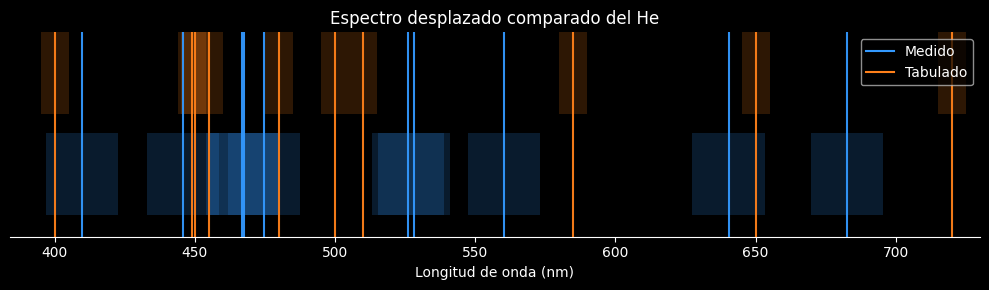

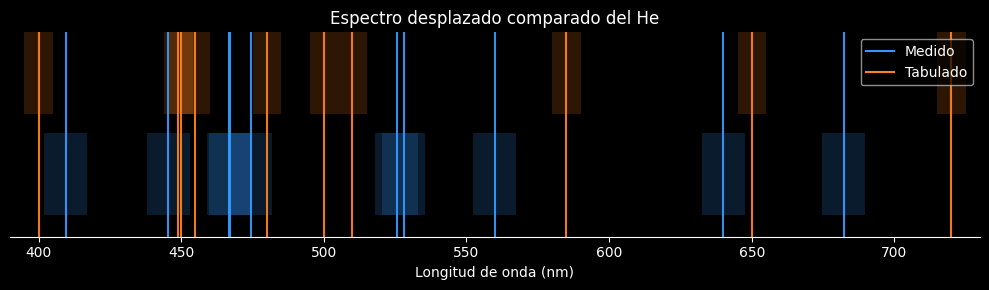

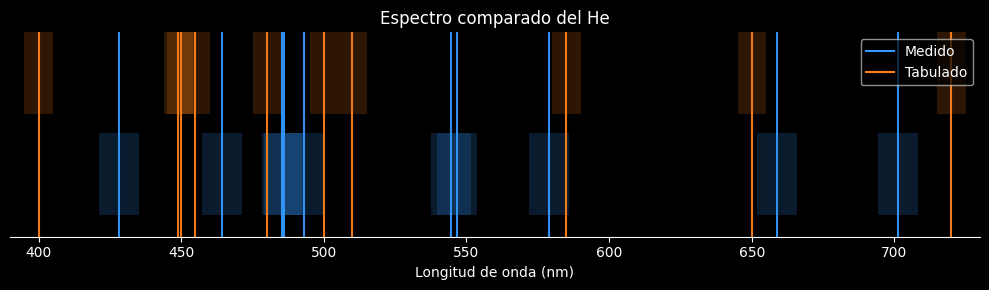

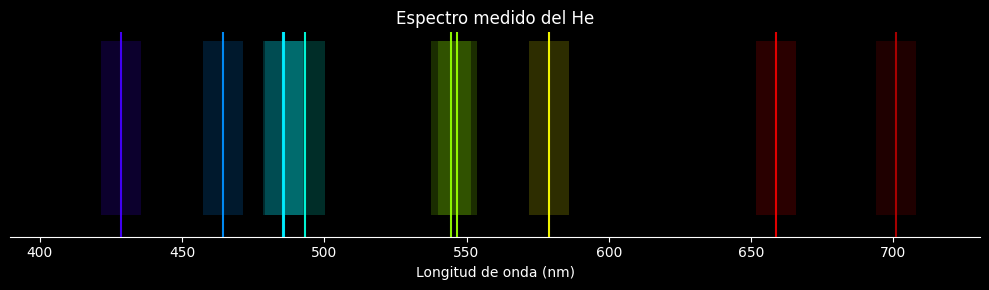

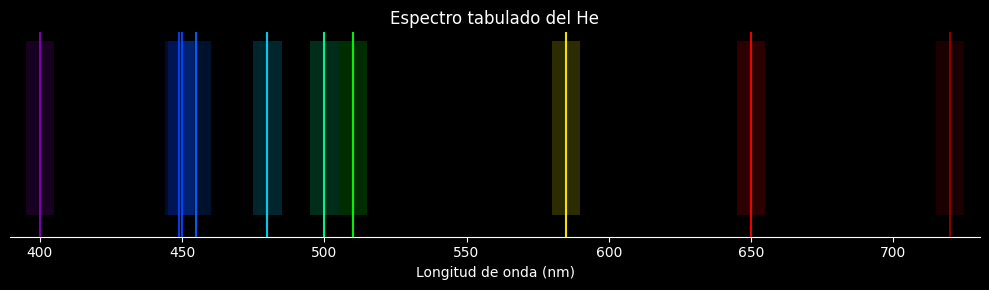

Minimos cuadrados:
 -19+/-11 nm 
 -19+/-11 Minutos
Proyeccion del coseno: 0.99920+/-0.00033
Proyección:
 -18.8+/-2.7 nm 
 -19.4+/-2.8 Minutos
Proyeccion del coseno: 0.99907+/-0.00022


In [46]:
error_sist("He")


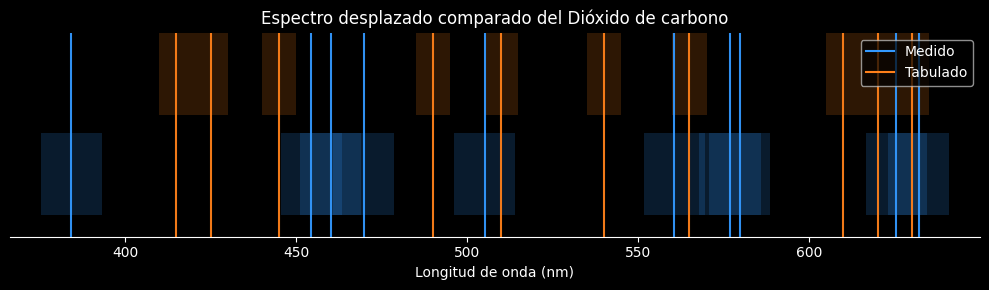

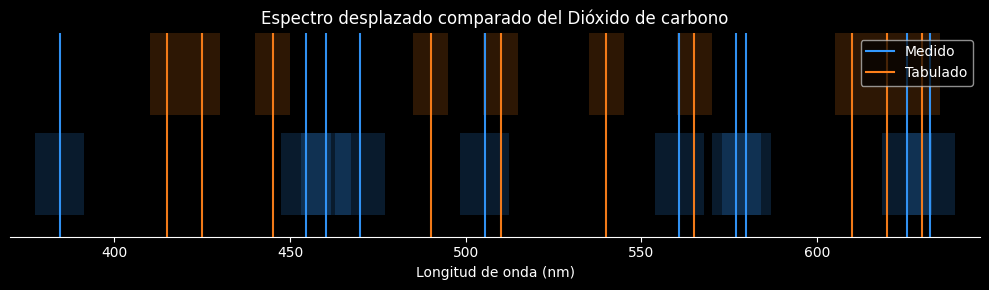

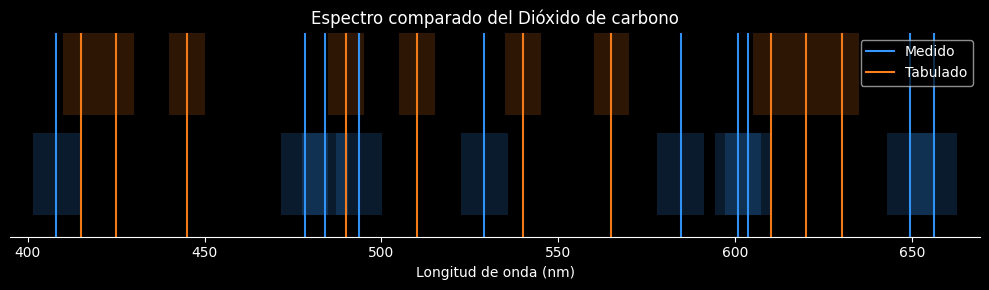

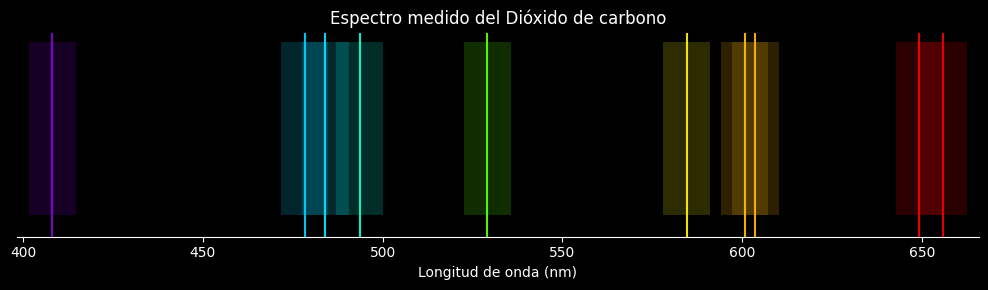

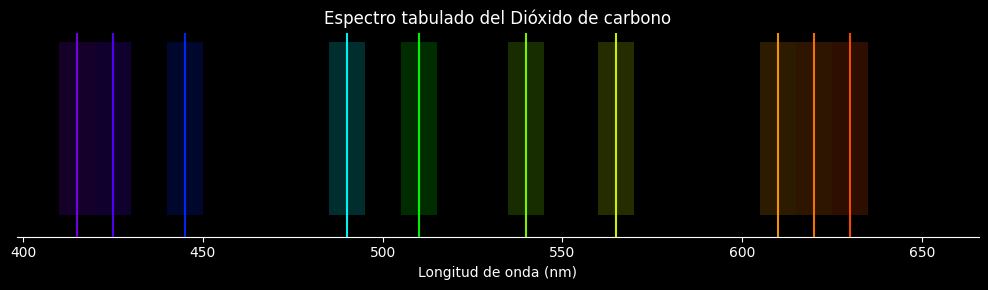

Minimos cuadrados:
 -24+/-6 nm 
 -25+/-6 Minutos
Proyeccion del coseno: 0.99870+/-0.00031
Proyección:
 -23.8+/-2.6 nm 
 -24.5+/-2.7 Minutos
Proyeccion del coseno: 0.99875+/-0.00024


In [47]:
error_sist("Dióxido de carbono")

valor real del error sistemático -5
Desvíos estándar de los estimadores:
Proyección:        -5.0+/-1.6


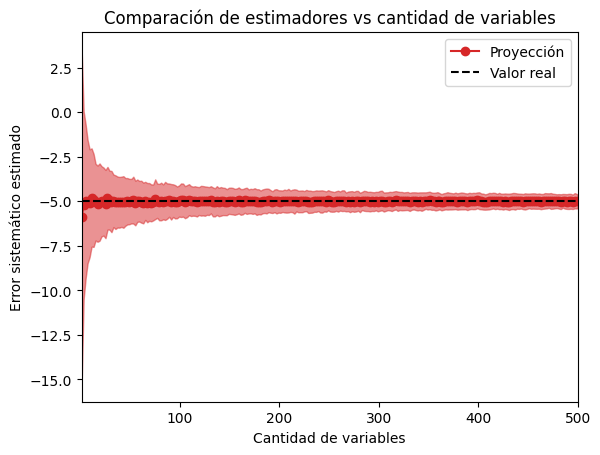

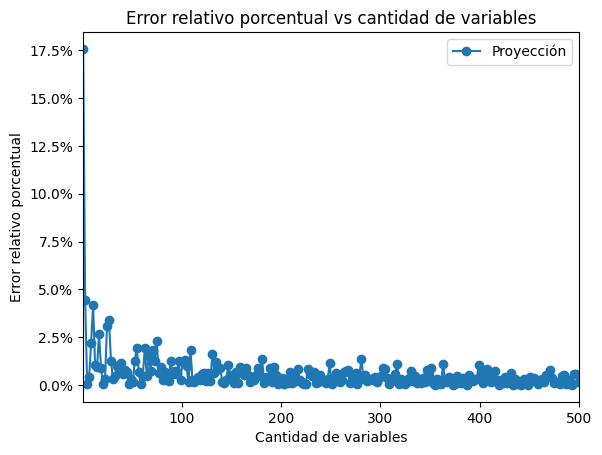

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties import unumpy
import matplotlib.ticker as mticker
# Parámetros
minimum,maximum,N = 400,600,6
cant = round((maximum - minimum) / N)
rep ,step= 500,2
mean,stdw = 5,3
desv = np.random.randn(rep,cant)*stdw+mean
N_variable = np.linspace(1,rep,int(round(rep/step)),dtype=int)
SigmaA,SigmaB = 7,5
# Generador de datos A y B
def generar_AB(cant, desv):
    A = np.random.randn(cant) * SigmaA + np.linspace(minimum,maximum,cant) # Ruido en A
    B = np.random.randn(cant) * SigmaB + np.linspace(minimum, maximum, cant) + desv  # Referencia B
    return A, B

def estimador_proy(A, B):
    # Ajuste lineal A = alpha + beta*B + ruido
    
    return np.sum(A - B) / len(A)

# --- Simulación Monte Carlo ---
def monte_carlo_estimadores(rep, cant):
    res_proy= []

    for i in range(rep):
        A, B = generar_AB(cant, desv[i,:])
        res_proy.append(estimador_proy(A, B))

    # Convertimos a arrays
    res_proy = np.array(res_proy)
    return res_proy

def plot_estimadores_vs_N(N_variable,  R_PR, mean):
    plt.figure()
    plt.xlim(1,rep)
    plt.plot(N_variable, [r.n for r in R_PR], 'o-', label="Proyección",color='C3')
    plt.fill_between(N_variable, [r.n - r.s for r in R_PR], [r.n + r.s for r in R_PR], alpha=0.5,color='C3')
    plt.axhline(-mean, color='k', linestyle='--', label="Valor real")
    plt.xlabel("Cantidad de variables")
    plt.ylabel("Error sistemático estimado")
    plt.title("Comparación de estimadores vs cantidad de variables")
    plt.legend()
    plt.show()

    plt.figure()
    # Error porcentual
    plt.xlim(1,rep)
    valores_PR = np.array([unumpy.fabs(-mean-r)*100/mean for r in R_PR])
    N_PR = unumpy.nominal_values(valores_PR)
    S_PR = unumpy.std_devs(valores_PR)
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
    plt.plot(N_variable,N_PR,"o-",label="Proyección")
    plt.xlabel("Cantidad de variables")
    plt.ylabel("Error relativo porcentual")
    plt.title("Error relativo porcentual vs cantidad de variables")
    plt.legend()
    plt.show()

res_proy = monte_carlo_estimadores(rep, cant)

# --- Resultados ---
print("valor real del error sistemático", -mean)
print("Desvíos estándar de los estimadores:")
print(f"Proyección:        {ufloat(np.mean(res_proy), np.std(res_proy, ddof=1))}")

R_PR = []

for i in N_variable:
    desv = np.random.randn(rep,i)*stdw+mean
    
    res_proy = monte_carlo_estimadores(rep, i)
    R_PR.append(ufloat(np.mean(res_proy), np.std(res_proy, ddof=1)))

R_PR = np.array(R_PR)

plot_estimadores_vs_N(N_variable, R_PR,  mean)